In [3]:
# install the necessary extra libraries to run the script
!apt-get update
!apt-get install chromium chromium-driver
!pip install selenium
!pip install webdriver-manager
!pip install pandas

"apt-get" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"apt-get" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [4]:
# import selenium, BeautifulSoup and other libraries to run the script
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from pandas import DataFrame
from bs4 import BeautifulSoup
from IPython.display import Image, display, clear_output
import re
import time
import pandas as pd
import os, shutil

# define constants to define the maximum waiting time and maximum amount of reviews to collect
MAX_WAIT = 10

In [5]:
# define a function to take a screenshot of the headless browser and display it
def take_screenshot(driver):
    driver.save_screenshot("scraping_folder/pageImage.png")
    display(Image(filename="scraping_folder/pageImage.png"))
    print()

In [6]:
# define a function to take a screenshot of the headless browser and display it, then clean the outcome after a few seconds
def take_screenshot_and_clear(driver):
    driver.save_screenshot("scraping_folder/pageImage.png")
    display(Image(filename="scraping_folder/pageImage.png"))
    
    time.sleep(3)
    clear_output(wait=True)

In [15]:
def get_place_data(driver, response, wait):
    take_screenshot(driver)

    # get the place's name, some changes are performed to allow the folder creation
    name = response.find('h1', class_ = 'HjBfq').text
    pathname = name.replace('?','')
    pathname = pathname.replace('"','')
    pathname = pathname.replace('!...','')
    pathname = pathname.replace(':','')
    pathname = pathname.replace('/','')
    pathname = pathname.rstrip()
    #create restaurant's folder
    os.makedirs('Venezia//'+pathname, exist_ok=True)
    # get the number of reviews
    num_reviews = response.find('span', class_="AfQtZ").text

    # cast the number of reviews to the correct type
    num_reviews = int(num_reviews.split(' ')[0].replace('.', ''))
    
    # get the overall rating
    overall_rating = response.find_all('span', class_="DsyBj")[0].find('svg', class_='UctUV d H0')['aria-label'][10:13].replace(',', '.')

    # get the place's address, if it exists
    if response.find('div', class_='vQlTa H3') is not None:
        complete_address = response.find_all('div', class_='vQlTa H3')[1].find_all("span", class_='DsyBj cNFrA')[0].text
    else:
        complete_address = ""
    
    # get ranking
    ranking_string = response.find('div', class_='vQlTa H3').find_all("span", class_='DsyBj cNFrA')[0].text 
    #get price type and typology
    price_type= response.find('div', class_='vQlTa H3').find_all("span", class_='DsyBj DxyfE')[0].text 
    lastocc=price_type.rfind('€')
    
    price = price_type[0:lastocc+1]
    typology = price_type[lastocc+1:]   
    #get phone number
    phone_number = response.find_all('div', class_='vQlTa H3')[1].find_all("span", class_='DsyBj cNFrA')[1].text
    #get aspect ratings
    if len(response.find_all('div', class_='DzMcu'))>0:
        cooking_rating = response.find_all('div', class_='DzMcu')[0].find_all("span", class_='ui_bubble_rating')[0]
        cooking_rating=float(cooking_rating.get("class")[1].split('_')[1])
        cooking_rating=str(cooking_rating/10).replace(',', '.')
        
        service_rating = response.find_all('div', class_='DzMcu')[1].find_all("span", class_='ui_bubble_rating')[0]
        service_rating=float(service_rating.get("class")[1].split('_')[1])
        service_rating=str(service_rating/10).replace(',', '.')
    
        quality_rating = response.find_all('div', class_='DzMcu')[2].find_all("span", class_='ui_bubble_rating')[0]
        quality_rating=float(quality_rating.get("class")[1].split('_')[1])
        quality_rating=str(quality_rating/10).replace(',', '.')
    else:
        cooking_rating='Not present'
        service_rating='Not present'
        quality_rating='Not present'
    
    if len(response.find_all('div', class_='DzMcu'))==4:
        atmosphere_rating = response.find_all('div', class_='DzMcu')[3].find_all("span", class_='ui_bubble_rating')[0]
        atmosphere_rating=float(atmosphere_rating.get("class")[1].split('_')[1])
        atmosphere_rating=str(atmosphere_rating/10).replace(',', '.')
    else:
        atmosphere_rating='Not present'
    
    place={
        'name':name,
        'num_reviews':num_reviews,
        'overall_rating':overall_rating,
        'address':complete_address,
        'ranking_str':ranking_string,
        'price':price,
        'typology':typology,
        'phone_number':phone_number,
        'cooking_rating':cooking_rating,
        'service_rating':service_rating,
        'quality_rating':quality_rating,
        'atmosphere_rating':atmosphere_rating 
    }
    #save restaurants details
    df = DataFrame({'Place': place})
    out_path = 'Venezia\\'+pathname+"\\"+pathname+".xlsx"
    writer = pd.ExcelWriter(out_path , engine='xlsxwriter')
    df.to_excel(writer, sheet_name='sheet1')
    writer.save()
    

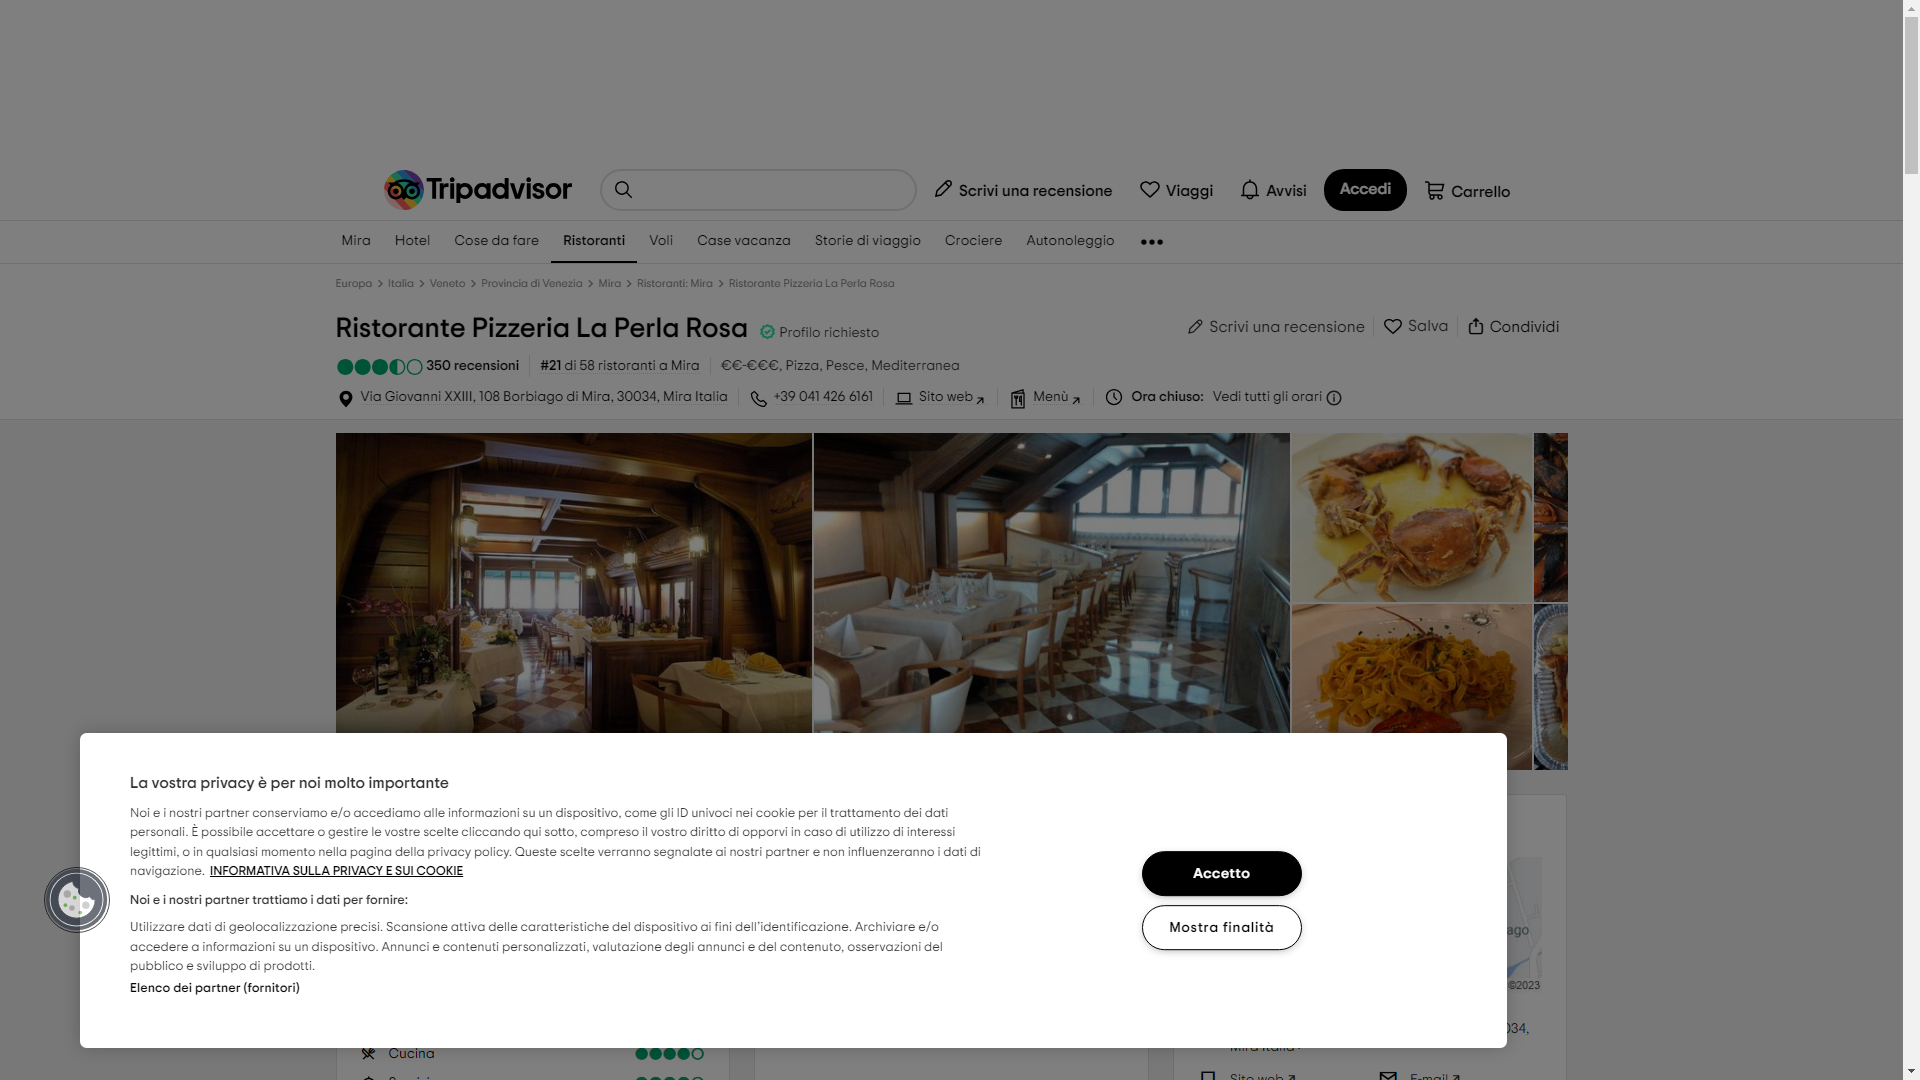

In [16]:
# kill the chrome process to ensure a fresh start
!pkill chrome

# define the options to run Chrome
# IMPORTANT: these options are quite essential, especially when running it in a remote environment like Google Colab
options = webdriver.ChromeOptions()
# define the size of the window
options.add_argument("--window-size=1920,1080")
# disable notifications to avoid useless interactions 
options.add_argument("--disable-notifications")
# disable the developer options
options.add_argument('--disable-dev-shm-usage')
# set the browser to be headless (i.e., the browser window will be hidden)
options.add_argument('--headless')
# set the browser to run all scripts
options.add_argument('--no-sandbox')

driver = webdriver.Chrome(options=options)

# define an element to wait until an event occurs
wait = WebDriverWait(driver, MAX_WAIT)

#load urls file
file_url=pd.read_csv('Venezia/Venezia review.CSV', sep=';')
num_of_urls=len(file_url)

#iterate over each url
for index in range(0, num_of_urls):
    #if the url has not yet been inspected
    if(file_url['Details'][index]==0):
        #take the url
        url=file_url['Urls'][index]
        # get the page with Selenium
        driver.get(url)
        response = BeautifulSoup(driver.page_source, 'html.parser')
        #get restaurants details
        get_place_data(driver, response, wait)
        #mark the url as considered
        file_url.loc[index, 'Details'] = 1
        #update the file
        file_url.to_csv("Venezia/Venezia review.CSV", index=False)
        
        time.sleep(2)
        clear_output(wait=True)

# close the driver
driver.close()
driver.quit()